# CNN with a Trainable Embedding Layer
## Redoing with 80/10/10 split

In [1]:
%matplotlib inline

import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 

In [2]:
import ktrain
from ktrain import text

import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

## Build test and training sets & define preprocessing

In [15]:
NUM_WORDS = 50000
MAXLEN = 5000
NGRAM_RANGE = 1

In [16]:
train, test, preproc = text.texts_from_csv('../data/train_80_10_10.csv',
                                          'cleaned_contents',
                                          label_columns=['Discrimination_Label'],
                                          val_filepath='../data/val_80_10_10.csv',
                                          max_features=NUM_WORDS,
                                          maxlen=MAXLEN,
                                          ngram_range=NGRAM_RANGE)

detected encoding: utf-8 (if wrong, set manually)
language: en
Word Counts: 17531
Nrows: 647
647 train sequences
train sequence lengths:
	mean : 1501
	95percentile : 3939
	99percentile : 7668
x_train shape: (647,5000)
y_train shape: (647, 2)
Is Multi-Label? False
81 test sequences
test sequence lengths:
	mean : 1510
	95percentile : 4141
	99percentile : 5507
x_test shape: (81,5000)
y_test shape: (81, 2)


## Build the model

In [28]:
def _build_cnn(maxlen, max_features, embed_dim, filters, kernels,
               dropout=0.1,
               loss_func='categorical_crossentropy',
               activation = 'softmax', metrics=['accuracy'],
               verbose=1, optimizer='adam'):
    
    embedding_matrix = np.ones((max_features, 1))
    embedding_matrix[0] = 0

    # set up the model
    inp = tf.keras.layers.Input(shape=(maxlen,))
    x = tf.keras.layers.Embedding(max_features, embed_dim, input_length=maxlen, 
                                  trainable=True)(inp)
    x0 = tf.keras.layers.Conv1D(filters=filters,
                               kernel_size=kernels[0],
                               activation='relu')(x)
    x0 = tf.keras.layers.MaxPool1D(pool_size=maxlen - kernels[0] + 1)(x0)

    x1 = tf.keras.layers.Conv1D(filters=filters,
                                kernel_size=kernels[1],
                                activation='relu')(x)
    x1 = tf.keras.layers.MaxPool1D(pool_size=maxlen - kernels[1] + 1)(x1)
    
    x2 = tf.keras.layers.Conv1D(filters=filters,
                                kernel_size=kernels[2],
                                activation='relu')(x)
    x2 = tf.keras.layers.MaxPool1D(pool_size=maxlen - kernels[2] + 1)(x2)
    
    x3 = tf.keras.layers.Conv1D(filters=filters,
                                kernel_size=kernels[3],
                                activation='relu')(x)
    x3 = tf.keras.layers.MaxPool1D(pool_size=maxlen - kernels[3] + 1)(x3)

    x4 = tf.keras.layers.Conv1D(filters=filters,
                                kernel_size=kernels[4],
                                activation='relu')(x)
    x4 = tf.keras.layers.MaxPool1D(pool_size=maxlen - kernels[4] + 1)(x4)

    x = tf.keras.layers.concatenate([x0, x1, x2, x3, x4])

    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Flatten()(x)
    outputs = tf.keras.layers.Dense(2, activation=activation)(x)
    model = tf.keras.Model(inputs=inp, outputs=outputs)
    model.compile(loss=loss_func,
                  optimizer=optimizer,
                  metrics=metrics)
    return model

In [29]:
model = _build_cnn(MAXLEN, 50000, 100, filters=32, kernels=[2, 3, 4, 5, 6], dropout=0.4)
learner = ktrain.get_learner(model, train_data=train, val_data=test)

In [30]:
learner.model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 5000)]       0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 5000, 100)    5000000     input_7[0][0]                    
__________________________________________________________________________________________________
conv1d_22 (Conv1D)              (None, 4999, 32)     6432        embedding_6[0][0]                
__________________________________________________________________________________________________
conv1d_23 (Conv1D)              (None, 4998, 32)     9632        embedding_6[0][0]                
____________________________________________________________________________________________

## Define and train the model

### Find a good initial learning rate

This is a method that was developed at the Naval Research Laboratory.  It's been promoted by Jeremy Howard.

simulating training for different learning rates... this may take a few moments...
Train on 647 samples
Epoch 1/5


/usr/local/lib/python3.6/dist-packages/ktrain/core.py:476: UserWarning: max_epochs is being set to 5 since steps per epoch is small. If you wish to estimate LR using more epochs, set max_epochs manually.
  'If you wish to estimate LR using more epochs, set max_epochs manually.')


647/647 [==============================] - 4s 6ms/sample - loss: 0.6928 - accuracy: 0.5580
Epoch 2/5
647/647 [==============================] - 3s 5ms/sample - loss: 0.6907 - accuracy: 0.5533
Epoch 3/5
647/647 [==============================] - 3s 5ms/sample - loss: 0.6809 - accuracy: 0.5719
Epoch 4/5
647/647 [==============================] - 3s 5ms/sample - loss: 0.7601 - accuracy: 0.5703
Epoch 5/5
647/647 [==============================] - 3s 5ms/sample - loss: 0.7006 - accuracy: 0.5719


done.
Visually inspect loss plot and select learning rate associated with falling loss


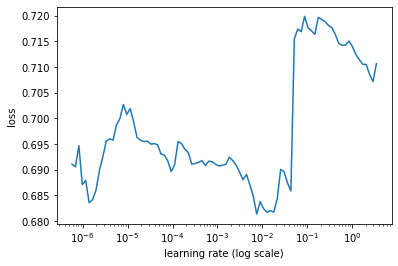

In [31]:
learner.lr_find(show_plot=True)

### Train

In [32]:
learner.autofit(0.01, early_stopping=5)

reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.01...
Train on 647 samples, validate on 81 samples
Epoch 1/1024
647/647 [==============================] - 4s 6ms/sample - loss: 0.6858 - accuracy: 0.5657 - val_loss: 0.6436 - val_accuracy: 0.6543
Epoch 2/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.5913 - accuracy: 0.6893 - val_loss: 0.6415 - val_accuracy: 0.6543
Epoch 3/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.4227 - accuracy: 0.8223 - val_loss: 0.7806 - val_accuracy: 0.6049
Epoch 4/1024
640/647 [============================>.] - ETA: 0s - loss: 0.2725 - accuracy: 0.8969
Epoch 00004: Reducing Max LR on Plateau: new max lr will be 0.005 (if not early_stopping).
647/647 [==============================] - 3s 5ms/sample - loss: 0.2730 - accuracy: 0.8964 - val_loss: 1.0545 - val_accuracy: 0.5679
Epoch 5/1024
647/647 [==============================] - 3s 5ms/

## Examine results

In [12]:
learner.validate(class_names=preproc.get_classes())

              precision    recall  f1-score   support

           0       0.43      0.18      0.26        33
           1       0.60      0.83      0.70        48

    accuracy                           0.57        81
   macro avg       0.51      0.51      0.48        81
weighted avg       0.53      0.57      0.52        81



array([[ 6, 27],
       [ 8, 40]])

In [13]:
test_x = list(pd.read_csv('../data/test_80_10_10.csv')['cleaned_contents'])
predictor = ktrain.get_predictor(learner.model, preproc=preproc)
y_hat = np.array(predictor.predict(list(test_x)), dtype=np.int64)
y = np.array(pd.read_csv('../data/test_80_10_10.csv')['Discrimination_Label'])

In [14]:
print(classification_report(y, y_hat))
print(confusion_matrix(y, y_hat))

              precision    recall  f1-score   support

           0       0.91      0.27      0.42        37
           1       0.61      0.98      0.75        44

    accuracy                           0.65        81
   macro avg       0.76      0.62      0.59        81
weighted avg       0.75      0.65      0.60        81

[[10 27]
 [ 1 43]]


## Explain a prediction

In [16]:
predictor.explain('As the perpetrator is the sole breadwinner for his family, I reduce his sentence by two years.')

### Which elements of the penultimate dense layer contribute most strongly to a positive prediction?

In [52]:
final_layer_weights = learner.model.weights[13].numpy()

In [53]:
final_layer_weights_diff = final_layer_weights[:,1] - final_layer_weights[:,0]

In [54]:
final_layer_weights_diff.argsort()

array([55, 30, 10, 57, 25, 34, 28, 11, 41, 60, 27, 15, 21,  6, 43, 45, 56,
       39, 38,  4, 35, 62,  7, 22, 61,  9, 17, 46, 26, 48, 53, 40,  1, 36,
       12, 19, 20, 51,  2, 16, 63, 44, 33, 23, 58, 14, 32, 18,  5, 47, 59,
       24, 49, 50, 13, 42,  3,  8,  0, 37, 52, 29, 31, 54])

In [57]:
final_layer_weights_diff[54]

0.45901084

### Which filter contributes most strongly to element 54?

In [68]:
filter_contrib_54 = learner.model.weights[11][:,54].numpy()

In [69]:
filter_contrib_54.argsort()

array([ 88, 102,   8,  68, 156,  14,  26,  50,  65, 101, 137,  91,   1,
       111,  90,  93, 107,  51, 113,  31,  40,  73,  59, 134, 149,   3,
       108, 106, 159,  74, 132,  70, 155,  67,  54,  58, 158, 117,  66,
        15, 152,  20, 112,  44,  82, 129, 138,  29, 123,  56, 105, 103,
        78,  86,  85, 139, 131, 140, 150, 110,   4, 135,  75,  25,  98,
       100,  99,  13,  38,  12, 115,  37,   6, 120,  80,  92,   5,  94,
       126, 148,  16,  21, 146,  57, 124,  39,  33, 122,  45,  17, 133,
        32,  97,  76, 125, 147, 109,  62,   0,  43, 136,  83,  61,  18,
        47,  19,  35,  46,  64, 145,  69, 154,  96, 130, 151, 144,  55,
       127,  28,   2,  77,  48, 141,  60,  81,  11,  27,  63, 118, 114,
        84,  87,  24,  41,  89, 142,  42,  71, 121,  34,  23,   9,  53,
        36,  95,  72,  79,   7,  22, 116, 153,  52,  30,  10, 143, 104,
       119, 157, 128,  49])

### Examine filters

In [31]:
k2 = learner.model.weights[1]

In [33]:
k2.shape

TensorShape([2, 100, 32])

In [40]:
f21 = k2[:,:,0]

TensorShape([2, 100])